<a href="https://colab.research.google.com/github/chxtio/Image-Classification-Using-AlexNet-CNN/blob/master/Image_Classification_Using_AlexNet_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image-Classification-using-AlexNet-CNN-Model

Based on [Multi-Class Image Classification using Alexnet Deep Learning Network implemented in Keras API](https://medium.com/analytics-vidhya/multi-class-image-classification-using-alexnet-deep-learning-network-implemented-in-keras-api-c9ae7bc4c05f)

Modifications:
*   Switched to Colab to enable GPU runtime
*   Improved slow file reading from Google Drive
    *   Uploaded zip file of dataset to Drive
    *   Mounted Drive in Colab and extracted dataset
*   Enabled model checkpointing during training
    *   Saved weights to Drive to resume training from last saved epoch





In [ ]:
# Check whether GPU is connected
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation,BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

## Mount Google Drive (containing dataset) to colab
[Connect to Google Drive account separate from Colab Account](https://stackoverflow.com/questions/69822304/google-colab-google-drive-can%C2%B4t-be-mounted-anymore-browser-popup-google-dri)


In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse
# Click URL on last line of output to authenticate Google Drive account



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: www-browser: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links2: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: elinks: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: links: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: lynx: not found
/usr/bin/xdg-open: 851: /usr/bin/xdg-open: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive
# Should see "Access token retrieved correctly." if successful

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 123947 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-36build1_amd64.deb ...
Unpacking w3m (0.5.3-36build1) ...
Setting up w3m (0.5.3-36build1) ...
Processing triggers for mime-support (3.60ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


In [ ]:
# Check Drive access
# Files will be present in "/content/drive/MyDrive".
!ls "/content/drive/MyDrive/alexnet_cnn_classifier"

dataset.zip


## Importing the Dataset

**Dataset:** [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)

**Content**
This Data contains around 25k images of size 150x150 distributed under 6 categories.
{'buildings' -> 0,
'forest' -> 1,
'glacier' -> 2,
'mountain' -> 3,
'sea' -> 4,
'street' -> 5 }

There are 14K images in training set, 3K in test set and 7K in Prediction set.

In [ ]:
# Create folder in Colab to load dataset from
!mkdir temp

In [ ]:
# Unzip dataset file from Drive into Colab
!unzip "/content/drive/MyDrive/alexnet_cnn_classifier/dataset.zip" -d "/temp"

Streaming output truncated to the last 5000 lines.
  inflating: /temp/dataset/seg_train/seg_train/mountain/7539.jpg  
  inflating: /temp/dataset/seg_train/seg_train/mountain/7551.jpg  
  inflating: /temp/dataset/seg_train/seg_train/mountain/7560.jpg  
  inflating: /temp/dataset/seg_train/seg_train/mountain/7565.jpg  
  inflating: /temp/dataset/seg_train/seg_train/mountain/7578.jpg  
  inflating: /temp/dataset/seg_train/seg_train/mountain/7581.jpg  
  inflating: /temp/dataset/seg_train/seg_train/mountain/7586.jpg  
  inflating: /temp/dataset/seg_train/seg_train/mountain/7647.jpg  
  inflating: /temp/dataset/seg_train/seg_train/mountain/7652.jpg  
  inflating: /temp/dataset/seg_train/seg_train/mountain/7654.jpg  
  inflating: /temp/dataset/seg_train/seg_train/mountain/7662.jpg  
  inflating: /temp/dataset/seg_train/seg_train/mountain/767.jpg  
  inflating: /temp/dataset/seg_train/seg_train/mountain/7672.jpg  
  inflating: /temp/dataset/seg_train/seg_train/mountain/7679.jpg  
  inflating:

In [ ]:
!ls "/temp/dataset"

seg_pred  seg_test  seg_train


Using Image Data Generator to generate batches of tensor image data and real-time data augmentation
[tf.keras.preprocessing.image.ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [ ]:
# Import the dataset. ImageDataGenerator will infer the labels from name of subdirectories
path = "/temp/dataset/seg_train/seg_train"

# Configure any desired transformations and normalization operations to be done on image data during training
train_datagen = ImageDataGenerator(rescale=1. / 255)
# Instantiate generators of augmented image batches and their labels, which can then be accepted as input into Keras model methods
train = train_datagen.flow_from_directory(path, target_size=(227,227), class_mode='categorical') # Change target size to 227 x 227 to match AlexNet input size of (227 x 227 x 3)

Found 14034 images belonging to 6 classes.


In [ ]:
# Generates batches of tensor image data with real-time data augmentation w/ default batch size of 32
type(train_datagen)

keras.preprocessing.image.ImageDataGenerator

In [ ]:
# Iterator for reading images from a directory on disk[5]
type(train)

keras.preprocessing.image.DirectoryIterator

In [ ]:
# Steps per epoch = datapoints / batch size
print("Steps per epoch: ", len(train))
# Default batch size: 32
print("Batch Size for Input Image : ",train[0][0].shape)
print("Batch Size for Output Image : ",train[0][1].shape)
# Dimensions of first image and associated output in first batch
print("Image Size of first image : ",train[0][0][0].shape)
print("Output of first image : ",train[0][1][0].shape)

Steps per epoch:  439
Batch Size for Input Image :  (32, 227, 227, 3)
Batch Size for Output Image :  (32, 6)
Image Size of first image :  (227, 227, 3)
Output of first image :  (6,)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[1. 0. 0. 0. 0. 0.]')

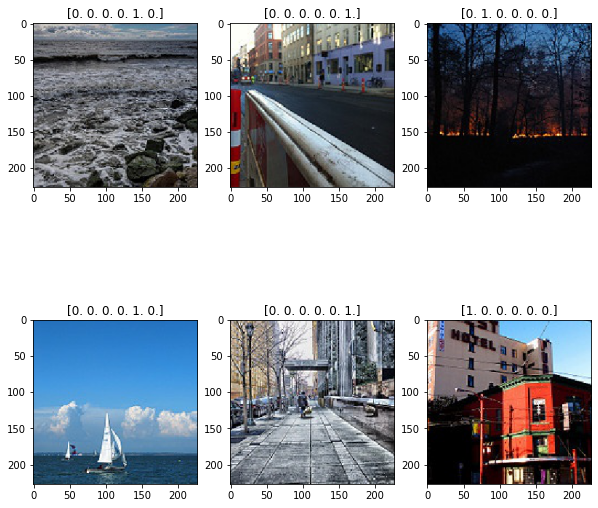

In [ ]:
# Hardcoded examples from 1st batch (1 pic per category)
fig , axs = plt.subplots(2,3 ,figsize = (10,10))

axs[0][0].imshow(train[0][0][12])
axs[0][0].set_title(train[0][1][12])

axs[0][1].imshow(train[0][0][10])
axs[0][1].set_title(train[0][1][10])

axs[0][2].imshow(train[0][0][5])
axs[0][2].set_title(train[0][1][5])

axs[1][0].imshow(train[0][0][20])
axs[1][0].set_title(train[0][1][20])

axs[1][1].imshow(train[0][0][25])
axs[1][1].set_title(train[0][1][25])

axs[1][2].imshow(train[0][0][3])
axs[1][2].set_title(train[0][1][3])

# Construct AlexNet Deep Learning Network


In [ ]:
# Define model
def AlexNet(input_shape):
    
    # Input: 227x227x3
    X_input = Input(input_shape)
    
    # Convolution Layer: 96 11x11 filters, 'same' padding, stride of 4
    X = Conv2D(96,(11,11),strides = 4,name="conv0")(X_input)
    X = BatchNormalization(axis = 3 , name = "bn0")(X)
    # forward pass
    X = Activation('relu')(X)
    # Output: 55x55x96
    
    # MaxPooling layer: 3x3, stride of 2
    X = MaxPooling2D((3,3),strides = 2,name = 'max0')(X)
    # Output: 27x27x96
    
    # Convolution Layer: 256 5x5 filters, 'same' padding
    X = Conv2D(256,(5,5),padding = 'same' , name = 'conv1')(X)
    X = BatchNormalization(axis = 3 ,name='bn1')(X)
    X = Activation('relu')(X)
    # Output: 27x27x256

    # MaxPooling layer: 3x3, stride of 2
    X = MaxPooling2D((3,3),strides = 2,name = 'max1')(X)
    # Output: 13x13x256
    
    # Convolution Layer applied twice: 384 3x3 filters, 'same' padding
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    # Output: 13x13x384
    
    # 2nd time
    X = Conv2D(384, (3,3) , padding = 'same' , name='conv3')(X)
    X = BatchNormalization(axis = 3, name = 'bn3')(X)
    X = Activation('relu')(X)
    # Output: 13x13x384
    
    # Convolution Layer: 256 3x3 filters, 'same' padding
    X = Conv2D(256, (3,3) , padding = 'same' , name='conv4')(X)
    X = BatchNormalization(axis = 3, name = 'bn4')(X)
    X = Activation('relu')(X)
    # Output: 13x13x256 

    # MaxPooling layer: 3x3, stride of 2
    X = MaxPooling2D((3,3),strides = 2,name = 'max2')(X)
    # Output: 6x6x256 = 9216

    # Layer is flattened out
    X = Flatten()(X)
    
    # Fully Connected Layer with 4096 units 
    X = Dense(4096, activation = 'relu', name = "fc0")(X)
    
    # 2nd Fully Connected Layer with 4096 units
    X = Dense(4096, activation = 'relu', name = 'fc1')(X) 
    
    # Connect to Softmax layer of 6 units (output for classification into 6 classes)
    X = Dense(6,activation='softmax',name = 'fc2')(X)
    
    model = Model(inputs = X_input, outputs = X, name='AlexNet')

    
    return model

In [ ]:
# # Create model instance using shape of image
# alex = AlexNet(train[0][0].shape[1:])

In [ ]:
# # Display model's architecture
# alex.summary()

# Optimization Using Adam

Compile model using [Keras adam optimizer](https://keras.io/api/optimizers/) with [cross-entropy loss](https://keras.io/api/losses/)

In [ ]:
# # Compile defines the loss function, the optimizer and the metrics
# alex.compile(optimizer='adam', 
#              loss='categorical_crossentropy')

# Save Checkpoints During Training

Save and load models using [tf.keras.callbacks.ModelCheckpoint](https://keras.io/api/callbacks/#modelcheckpoint) callback class

In [ ]:
from keras.callbacks import ModelCheckpoint
# Save model to Google Drive after every epoch- enables training to restart from last saved epoch
checkpoint_path = "/content/drive/MyDrive/model/weights-{epoch:02d}.hdf5" # save model to hdf5 file after each epoch

# Create ModelCheckpoint object
checkpoint = ModelCheckpoint(filepath=checkpoint_path,                             
                             verbose=1)

callbacks_list = [checkpoint]

Train model using [fit_generator](https://pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/) and new callback

In [ ]:
# alex.fit_generator(train, 
#                    epochs=50,
#                    callbacks=callbacks_list) # Pass callbacks list to training

# Resume training from saved model

In [ ]:
from keras.models import load_model

# Load_model automatically compiles model with the optimizer saved along with the model
alex = load_model("/content/drive/MyDrive/model/weights-19.hdf5")

# Check its architecture
alex.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv0 (Conv2D)              (None, 55, 55, 96)        34944     
                                                                 
 bn0 (BatchNormalization)    (None, 55, 55, 96)        384       
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max0 (MaxPooling2D)         (None, 27, 27, 96)        0         
                                                                 
 conv1 (Conv2D)              (None, 27, 27, 256)       614656    
                                                                 
 bn1 (BatchNormalization)    (None, 27, 27, 256)       1024

In [ ]:
alex.fit_generator(train, 
                   epochs=50,
                   callbacks=callbacks_list,
                   initial_epoch=3)

Epoch 4/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


439/439 [==============================] - ETA: 0s - loss: 0.2684
Epoch 4: saving model to /content/drive/MyDrive/model/weights-04.hdf5
439/439 [==============================] - 62s 120ms/step - loss: 0.2684
Epoch 5/50
 52/439 [==>...........................] - ETA: 25s - loss: 0.2275

KeyboardInterrupt: ignored